### 2D Zeldovich approximation in numpy and scipy

In [1]:
import sys
import numpy as np
from   numpy import random, fft
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt

In [2]:
def tvscale(img, wsize=-1,scale=0, invert=False, _plot_size=(6,6)):

    plt.rcParams['figure.figsize'] = [_plot_size[0], _plot_size[1]]
    
    if invert==True:
        imgplot = plt.imshow(img,interpolation="none", origin='lower',cmap='gray')
    else:
        imgplot = plt.imshow(img,interpolation="none",cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
def fix_periodic2D(x,y, boxsize):

    s = (x<0).nonzero()
    x[s] = boxsize + x[s]
    s = (x>boxsize).nonzero()
    x[s] = x[s] - boxsize

    s = (y<0).nonzero()
    y[s] = boxsize + y[s]
    s = (y>boxsize).nonzero()
    y[s] = y[s] - boxsize
    
    return x,y

In [4]:
def G_o(z, o_m, o_L):
    ai = 1.0/(1.0+z)
    o_mz = o_m/( o_L*(1.0-1.0/ai**3) + o_m*(1.0/ai**3 - 1.0/ai**2) + 1.0/ai**2 )/ai**3
    o_Lz = o_L/( o_L*(1.0-1.0/ai**3) + o_m*(1.0/ai**3 - 1.0/ai**2) + 1.0/ai**2 )
    return (5.0/2.0)*o_mz/(o_mz**(4.0/7.0)-o_Lz+(1.+o_mz/2.0)*(1.+o_Lz/70.0))

def growth(o_m, o_L, z):
    return G_o(z, o_m, o_L)/G_o(0.0,o_m,o_L)/(1.0+z)

In [5]:
class Cosmology:
    """This object stores all relevant information wrt the background
    cosmology, parametrized by OmegaM, OmegaL and H0."""
    def __init__(self, H0, OmegaM, OmegaL, Sw=0.05, n_power=-0.98, gamma=4.0/9.0):
        self.H0       = H0
        self.OmegaM   = OmegaM
        self.OmegaL   = OmegaL
        self.OmegaK   = 1 - OmegaM - OmegaL
        self.Sw       = Sw
        self.n_power  = n_power
        self.gamma    = gamma
        self.grav_cst = (3.0/2.0) * OmegaM * H0**2

    def adot(self, a):
        return self.H0 * a * np.sqrt(self.OmegaL \
                + self.OmegaM * a**-3 \
                + self.OmegaK * a**-2)

In [6]:
def InitialConditions(Ngrid, boxsize, Cosmo):

    def make_P(n):
        return lambda k: np.where(k > 0, (k/mass_res)**n, 0)

    def scale_filter(t, gamma):
        return lambda K: np.exp(-(2 - gamma) * t + \
            (1 - gamma) * (np.cos(K[0]) + np.cos(K[1])) * \
             t + gamma * np.cos(K[0]) * np.cos(K[1]) * t)

    def make_K(N):
        idx = np.indices((N, N))
        return np.where(idx > N/2, idx - N, idx) * (2*np.pi / N)
    
    def generate_init_density():
        """generate initial condition with power-spectrum P"""
        
        P = make_P(Cosmo.n_power)
        F = scale_filter(Cosmo.Sw / mass_res, Cosmo.gamma)
        
        wn  = random.normal(0.0, 1.0, (Ngrid, Ngrid))
        km  = np.sqrt(km2)
        fwn = fft.fftn(wn) * np.sqrt(P(km)) * F(Km)
        
        dens = fft.ifftn(fwn).real
        return dens
        
    mass_res = boxsize / Ngrid
    
    # k-values, divide by resolution to get physical scales
    Km  = make_K(Ngrid)
    km2 = (Km**2).sum(axis=0)
    km2[0, 0] = 1

    dens = generate_init_density()
    
    return dens

In [7]:
def Zeldovich(dens, boxsize, zf, Cosmo):

    def make_K(N):
        idx = np.indices((N, N))
        return np.where(idx > N/2, idx - N, idx) * (2*np.pi / N)
    
    def compute_potential(dens):
        """compute Zeldovich displacement from initial density"""
        fDens = fft.fftn(dens)
        fPot  = fDens / km2 * mass_res**2
        pot = fft.ifftn(fPot).real
        return pot
        
    def den2psi(cosmology, a_init):
        u = compute_potential(dens)
        psi = u * a_init
        return psi
    
    def psi2pos(psi_x, psi_y, boxsize):
        
        ng = psi.shape[0] # number of particles in each dimension
        cell=boxsize/float(ng)
        #--- x,y coordinates
        gx, gy = np.meshgrid(np.linspace(cell/2, boxsize-cell/2, ng), np.linspace(cell/2, boxsize-cell/2, ng))

        print(">>>", ng, psi_x.shape)
        pos_x = gx + psi_x
        pos_y = gy + psi_y
        
        return pos_x, pos_y

    Nm = dens.shape[0]
    af = 1.0/(zf+1.0)
    mass_res  = boxsize / Nm
        
    # k-values, divide by resolution to get physical scales
    Km  = make_K(Nm)
    km2 = (Km**2).sum(axis=0)
    km2[0, 0] = 1

    #--- Hubble
    H_z = H0*np.sqrt(Cosmo.OmegaM/np.power(af,3) + Cosmo.OmegaL)

    #--- Matter content
    OmegaM_z = (Cosmo.OmegaM/np.power(af,3))/(Cosmo.OmegaM/np.power(af,3) + Cosmo.OmegaL)

    #--- Approximation to d log D / d log a
    f_z = np.power(OmegaM_z,5.0/9.0)

    #--- Growth function normalized at the present time
    D_z = growth(Cosmo.OmegaM, Cosmo.OmegaL, zf)

    pot = compute_potential(dens)
    
    grad = np.gradient(pot)
    px = grad[0] * D_z
    py = grad[1] * D_z

    fac = boxsize/Nm

    psi = np.zeros((dens.shape[0], dens.shape[1], 2))
    psi_x = grad[1] * D_z / fac
    psi_y = grad[0] * D_z / fac

    px, py = psi2pos(psi_x, psi_y, boxsize)

    return px,py


***
***

In [8]:
boxsize = 32.0  #--- box size
Nm  = 128    #--- particle grid size
Np  = Nm*Nm  #--- Number of particles

#--- Smoothing scale (initial conditions)
sigma_Mpc = 0.5
sigma_pix = sigma_Mpc*Nm/boxsize

#--- Power spectrum
Sw    =  0.05
n     = -0.98
gamma = 4.0/9.0

#--- Cosmological parameters
H0     = 68.0
OmegaM = 0.32
OmegaL = 0.68

#--- Cosmology
Cosmo = Cosmology(H0, OmegaM, OmegaL, Sw, n, gamma)

In [25]:
zf = 0.0

sneaky_factor = 10

dens = InitialConditions(Nm, boxsize, Cosmo)
dens = gaussian_filter(dens, sigma=(sigma_pix), order=0)

x,y = Zeldovich(dens * sneaky_factor, boxsize, zf, Cosmo)

>>> 128 (128, 128)


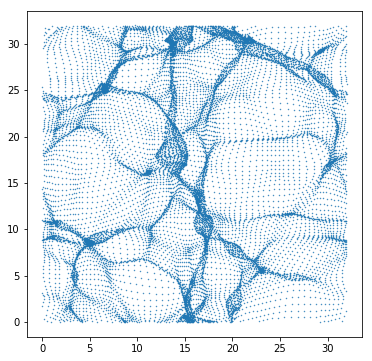

In [27]:
px,py = fix_periodic2D(x,y, boxsize)
plt.rcParams['figure.figsize'] = [6,6]
plt.scatter(px,py, marker='.',s=0.75)
plt.show()

***